# Riboswitch epistasis analysis notebook
### Generates figures for "Distinguishing Contact and Ensemble Epistasis in an RNA switch"
#### Daria R. Wonderlick, Julia R. Widom, Michael J. Harms

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter
from scipy import optimize
import pickle, copy, os, sys, glob
from tqdm import tqdm

import likelihood

import kapp_one_param
import two_state_three_param
import three_state_three_param
import three_state_four_param
import four_state_five_param

import warnings
#RuntimeWarning: divide by zero encountered in double_scalars
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Some pretty plot defaults
font = {'weight' : 'normal',
        'size'   : 16,
        'family' : 'Arial'}  

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


# 2AP_raw.csv contains raw 2AP binding data for mutant cycles
# 2AP_avg.csv contains averaged 2AP binding data for mutant cycles
# 2AP_corrected.csv contains 2AP binding data with low Mg and low RNA normalized to 0 fx_A

## Genotypes, mutant cycles, and fitting models

In [2]:
GENOS = ['xxxxx','xCxxx','xxAxx','Uxxxx',
         'xxxGx','xCxGx','xxAGx','UxxGx']

GENO_DICT = {'xxxxx':'WT','xCxxx':'C','xxAxx':'A','Uxxxx':'U',
             'xxxGx':'G','xCxGx':'GC','xxAGx':'GA','UxxGx':'GU'}

CYCLES = ['GC','GA','GU']

cycle_GC = ['xxxxx','xxxGx','xCxxx','xCxGx'] 
cycle_GA = ['xxxxx','xxxGx','xxAxx','xxAGx']
cycle_GU = ['xxxxx','xxxGx','Uxxxx','UxxGx']

CYCLE_DICT = {'GC':cycle_GC,'GA':cycle_GA,'GU':cycle_GU}

MODELS = ['2.3','3.3','3.4','4.4','4.5','kapp']

## Constants

In [3]:
R = 1.987e-3                                                           # kcal/mol-K
T = 27 + 273.15                                                        # K (binding measurements @ 27 degC)
BETA = 1 / (R*T)                                                       # kcal/mol

# Total RNA, ADE(2AP), and MG2+ concentrations in different units

RNA_M = 1e-6                                                           # 1000 nM Rt
ADE_M = 50e-9                                                          # 50 nM At
MG_LIST_M = [0.1e-3,1e-3,10e-3,100e-3]                                 # 0.1,1,10,100 mM Mt
MG_RANGE_M = np.exp(np.linspace(np.log(0.1e-3),np.log(100e-3),100))    # 0.1-100 mM Mt

RNA_nM = 1000  
RNA_RANGE_nM = np.exp(np.linspace(np.log(100),np.log(10000),100))
ADE_nM = 50

MG_LIST_nM = [0.1e6,1e6,10e6,100e6]
MG_RANGE_nM = np.exp(np.linspace(np.log(0.1e6),np.log(100e6),100))

MG_LIST_mM = [0.1,1,10,100]
MG_RANGE_mM = np.exp(np.linspace(np.log(0.1),np.log(100),100))


## Data import functions

In [4]:
def get_model_results(model='3.3',fitter='ml',run='runs.2'):
    '''
    Generate dataframe with fit results for all genotypes 
    for a given model and fitter.
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        estimate_files = glob.glob(os.path.join(model_dir,'*results*'))
        labelled_results = []
        for file in estimate_files:
            est_df = pd.read_csv(file)
            est_df.insert(1,'Geno',[os.path.basename(file)[:5]]*est_df.shape[0])
            labelled_results.append(est_df)
        result_df = pd.concat(labelled_results)
        return result_df

    else:
        print("Could not find fit results for model", model)
        return None
    
def get_model_likelihoods(model='3.3',fitter='ml',run='runs.2'):
    '''
    Generate dataframe with fit log-likelihoods for 
    all genotypes for a given model and fitter.
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        likelihood_files = glob.glob(os.path.join(model_dir,'*likelihood*'))
        labelled_likelihoods = []
        for file in likelihood_files:
            lnL_df = pd.read_csv(file)
            lnL_df.insert(0,'Geno',[os.path.basename(file)[:5]])
            lnL_df.insert(1,'Model',[model])
            labelled_likelihoods.append(lnL_df)
        likelihood_df = pd.concat(labelled_likelihoods)
        return likelihood_df

    else:
        print("Could not find likelihoods for model", model)
        return None

def get_model_samples(model='3.3',fitter='bayesian',run='runs.2',trimmed=True,size=100):
    '''
    Generate dictionary associating genotype with fit samples for 
    all genotypes for a given model and fitter.
    
    If trimmed=True, calls get_trimmed_samples to trim array to *size*
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        sample_files = glob.glob(os.path.join(model_dir,'*samples*'))
        sample_dict = {}
        for file in sample_files:
            sample_arr = pickle.load(open(file,'rb'))
            sample_dict[os.path.basename(file)[:5]] = sample_arr
        if trimmed:
            sample_dict = get_trimmed_samples(sample_dict,model=model,size=size)
        return sample_dict

    else:
        print("Could not find samples for model", model)
        return None
    
def get_trimmed_samples(sample_dict,model,size=100):
    '''Called by get_model_samples to trim sample arrays to *size*'''
    
    trimmed_dict = {}
    for geno,sample_arr in sample_dict.items():
        
        # specific constraints on 3.3 model
        if model == '3.3':
            if geno == 'xCxxx':
                # constrain n_mg > 0.8
                sample_arr = sample_arr[np.where(sample_arr[:,2] >= 0.8)] 
            elif geno == 'xxAGx':
                # constrain abs(logK_mg) < 100
                sample_arr = sample_arr[np.where((np.abs(sample_arr[:,1]) <= 100))]
                
        # trimmed array generated from *size* entries in sample array
        trimmed_arr = sample_arr[np.random.choice(sample_arr.shape[0],size=size,replace=False)]
        trimmed_dict[geno] = trimmed_arr
        
    return trimmed_dict


## AIC test

In [5]:
def rank_likelihoods(genos=GENOS,models=MODELS):
    '''
    Ranks ensemble models for each genotype by comparing log-likelihoods from ML fits.
    
    Calls get_model_likelihoods to generate combined dataframe for all models.
    
    Returns Dataframe sorted by genotype, then by log likelihood value of each model
    '''
    all_ll = pd.concat([get_model_likelihoods(model,'ml') for model in models])
    sorted_ll = all_ll.sort_values(by=['Geno','lnL'],ascending=[True,False])
    return sorted_ll

def calc_aic(genos=GENOS,models=MODELS):
    '''
    Perform AIC test to determine the probability of each model based on its ML fit.
    
    AIC value for a model penalizes extra fit parameters (k) and promotes 
    high-likelihood fits across all genotypes (ll_sum)
    aic = 2*k - 2*ll_sum
    
    AIC probability reflects the probability of a given model relative to
    the model with the lowest AIC value (most probable model)
    prob = np.exp((aic_min-aic)/2)
    
    Returns sorted dataframe with aic values and aic probabilities for each model
    '''
    model_dfs = [get_model_likelihoods(model,'ml') for model in models]
    aic_df = pd.DataFrame(columns=['Model','AICvalue','AICprob'])
                           
    for i,model_df in enumerate(model_dfs):
        model = model_df.iloc[0]['Model']
        ll_sum = model_df['lnL'].sum()
        num_params = model_df.iloc[0]['N']
        aic_value = 2*num_params - 2*ll_sum
        
        aic_df.loc[i]=[model,aic_value,'NaN']
    
    aic_min = aic_df['AICvalue'].min()
    aic_df['AICprob'] = np.exp((aic_min-aic_df['AICvalue'])/2)
    aic_df = aic_df.sort_values(by='AICprob',ascending=False)
    
    return aic_df
            

In [6]:
calc_aic() 

,Model,AICvalue,AICprob
1,3.3,-1033.257381,1.000000e+00
2,3.4,-1031.257365,3.678765e-01
3,4.4,-1030.539008,2.568698e-01
4,4.5,-996.126958,8.654283e-09
0,2.3,-630.572654,3.615120e-88
5,kapp,-227.218246,9.350307e-176


## Species concentration check

In [7]:
def conc_check(genos=GENOS,model="4.5"):
    '''
    Generates DataFrame with species concentrations based on a model's ML fit estimates
    to check whether fits reproduce total Mg2+, 2AP, and RNA concentrations.
    '''

    conc_check_df = pd.DataFrame(columns=['Geno','Model','Mt','M_free','At','A_free','Rt','fx_EA'])
    conc_check_list = []
    
    model_df = get_model_results(model=model,fitter='ml')
    
    for geno in genos:
        model_geno_df = model_df.loc[model_df.Geno == geno]
        n_mg = model_geno_df.estimate.values[-1]

        for mg_nM in MG_LIST_nM:
            if model.startswith('4'):
                E,D,EA,DA,A,M = four_state_five_param.species_conc(*model_geno_df.estimate,
                                                                   Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*D)+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA+EA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+D+EA+DA,precision=3)
                fx_EA = np.format_float_scientific(float(EA)/float(Rt),precision=3)
                
            elif model.startswith('3'):
                if model == '3.4':
                    E,D,DA,A,M = three_state_four_param.species_conc(*model_geno_df.estimate,
                                                                     Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                elif model == '3.3':
                    E,D,DA,A,M = three_state_three_param.species_conc(*model_geno_df.estimate,
                                                                      Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*D)+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+D+DA,precision=3)
                fx_EA = np.float64(0)
                
            elif model.startswith('2'):
                E,DA,A,M = two_state_three_param.species_conc(*model_geno_df.estimate,
                                                              Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+DA,precision=3)
                fx_EA = np.float64(0)
                
            conc_check_list.append(pd.DataFrame({'Geno':[geno],'Model':[model],
                                                 'Mt':Mt,'M_free':M_free,
                                                 'At':At,'A_free':A_free,
                                                 'Rt':Rt,'fx_EA':fx_EA}))
            
    conc_check_df = pd.concat(conc_check_list)
    return conc_check_df
      

In [8]:
conc_check(model='3.3')

,Geno,Model,Mt,M_free,At,A_free,Rt,fx_EA
0,xxxxx,3.3,1.000e+05,9.994e+04,5.000e+01,4.393e+01,1.000e+03,0.0
0,xxxxx,3.3,1.000e+06,9.992e+05,5.000e+01,1.625e+01,1.000e+03,0.0
0,xxxxx,3.3,1.000e+07,9.999e+06,5.000e+01,9.954e+00,1.000e+03,0.0
0,xxxxx,3.3,1.000e+08,1.e+08,5.000e+01,9.700e+00,1.000e+03,0.0
0,xCxxx,3.3,1.000e+05,9.999e+04,5.000e+01,4.972e+01,1.000e+03,0.0
0,xCxxx,3.3,1.000e+06,1.e+06,5.000e+01,4.931e+01,1.000e+03,0.0
0,xCxxx,3.3,1.000e+07,1.e+07,5.000e+01,4.836e+01,1.000e+03,0.0
0,xCxxx,3.3,1.000e+08,1.e+08,5.000e+01,4.652e+01,1.000e+03,0.0
0,xxAxx,3.3,1.e+05,9.999e+04,5.e+01,4.997e+01,1.e+03,0.0
0,xxAxx,3.3,1.000e+06,9.997e+05,5.000e+01,4.873e+01,1.000e+03,0.0


## Functions for plotting 2AP binding data

In [9]:
def plot_points(geno='xxxxx',ax=None,legend=False,title=None):
    '''
    Plot 2AP fractional saturation data points for a given genotype 
    from 2AP_corrected.csv. Returns None. 
    
    Curves plotted at four Mg2+ concentrations (0.1,1,10,100 mM) 
    with increasingly dark green coloration.
    '''
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)

    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        m_df = geno_df[geno_df.Mg == mg_mM]
        x = m_df.Rna
        y = m_df.FS_mean
        y_err = m_df.FS_std_cutoff
        ax.errorbar(x,y,y_err,fmt='o',color=colors[c],label=str(mg_mM)+' mM Mg')
        
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if legend:
        ax.legend(loc='upper left', fontsize='xx-small')
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None

def plot_estimates(geno='xxxxx',model='3.3',fitter='ml',ax=None,title=None):
    '''
    Plot 2AP fractional saturation binding curves calculated from fit
    estimates for a given genotype, model, and fitter. Returns None.
    
    Curves plotted at four Mg2+ concentrations (0.1,1,10,100 mM) 
    with increasingly dark green coloration.
    '''
    
    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]

    model_df = get_model_results(model=model,fitter=fitter)
    model_geno_df = model_df.loc[model_df.Geno == geno]
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        plot_df = pd.DataFrame({'Rna':RNA_RANGE_nM,'Mg':mg_mM})
        
        if model.startswith('4'): 
            fx_A = four_state_five_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '3.4':
            fx_A = three_state_four_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '3.3':
            fx_A = three_state_three_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '2.3':
            fx_A = two_state_three_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == 'kapp':
            mg_df = model_geno_df.loc[model_geno_df.Mg == mg_mM]
            fx_A = kapp_one_param.fx_A(*mg_df.estimate,some_df=plot_df)
            fx_A_high = kapp_one_param.fx_A(*(mg_df.estimate+mg_df.stdev),some_df=plot_df)
            fx_A_low = kapp_one_param.fx_A(*(mg_df.estimate-mg_df.stdev),some_df=plot_df)
            ax.fill_between(plot_df.Rna,fx_A_low,fx_A_high,alpha=0.25,color=colors[c])
            
        ax.plot(plot_df.Rna,fx_A,lw=3,color=colors[c])
            
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None
    
def plot_samples(geno,model='3.3',fitter='ml',trimmed=True,
                 sample_frac=0.05,alpha=0.1,ax=None,title=None):
    '''
    Plot 2AP fractional saturation binding curves calculated from sample
    estimates for a given genotype, model, and fitter. Returns None.
    
    Curves plotted at four Mg2+ concentrations (0.1,1,10,100 mM) 
    with increasingly dark green coloration.
    
    sample_frac determines the fraction of sample replicates to be plotted.
    '''
    
    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]
    
    sample_dict = get_model_samples(model,fitter,trimmed=trimmed)
    sample_arr = sample_dict[geno]
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)
        
    spacing = int(sample_frac*len(sample_arr))
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        plot_df = pd.DataFrame({'Rna':RNA_RANGE_nM,'Mg':mg_mM})
        for s in range(0,len(sample_arr),spacing):
            estimates = sample_arr[s]
            
            if model.startswith('4'): 
                fx_A = four_state_five_param.fx_A(*estimates,some_df=plot_df)
            elif model == '3.4':
                fx_A = three_state_four_param.fx_A(*estimates,some_df=plot_df)
            elif model == '3.3':
                fx_A = three_state_three_param.fx_A(*estimates,some_df=plot_df)
            elif model == '2.3':
                fx_A = two_state_three_param.fx_A(*estimates,some_df=plot_df)
            elif model == 'kapp':
                print(f'Cannot plot samples for {model}')
                return None
            ax.plot(plot_df.Rna,fx_A,lw=3,alpha=alpha,color=colors[c])
            
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None


def plot_groupedfits(genos=GENOS,model='3.3',fitter='ml',ml_estimates=False,
                     points=True,estimates=False,samples=False,trimmed=True,plot_kapp=False,
                     sample_frac=0.05,alpha=0.1,legend=False,savefig=False,file=None):
    '''
    Organizing scheme for plotting 2AP binding curves for 8 genotypes (two rows of 4)
    for a given model and fitter. Returns None.
    
    Curves plotted at four Mg2+ concentrations (0.1,1,10,100 mM) with increasingly dark green coloration.
    
    Can specify plotting points (points=True), fit estimates with alpha=1 (estimates=True),
    trimmed/untrimmed fit samples with alpha=alpha (samples=True), or apparent binding fits (plot_kapp=True).
    
    If plotting bayesian samples, ml_estimates=True overlays the ML result.
    
    Since Kapp model has no bayesian samples, stdev region plotted with alpha=0.25 shading.
    '''

    fig, axes = plt.subplots(ncols=4,nrows=2,sharey=True,squeeze=False,figsize=(20,10)) 
    
    pbar = tqdm(range(8))
    #for i in range(num_plots):
    for i in pbar:
        geno = genos[i]
        pbar.set_description("Plotting %s" % GENO_DICT[geno])
        
        #organize subplot layout 
        j = 0
        k = i
        if i >= 4:
            j = 1
            k = i-4
            
        if samples:
            plot_samples(geno=geno,model=model,fitter=fitter,sample_frac=sample_frac,
                         alpha=alpha,ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})')
        if estimates:
            plot_estimates(geno=geno,model=model,fitter=fitter,ax=axes[j,k],
                           title=f'{GENO_DICT[geno]} ({model})') 
        if ml_estimates:
            plot_estimates(geno=geno,model=model,fitter='ml',ax=axes[j,k],
                           title=f'{GENO_DICT[geno]} ({model})')    
        if points:
            plot_points(geno=geno,ax=axes[j,k],legend=legend,title=f'{GENO_DICT[geno]} ({model})') 
        
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None
        

# Figure 2A: 2AP binding curves for all genotypes fit to 3.3 ensemble model

#### Bayesian samples with ML fit overlay

Plotting GU: 100%|██████████| 8/8 [01:17<00:00,  9.63s/it]


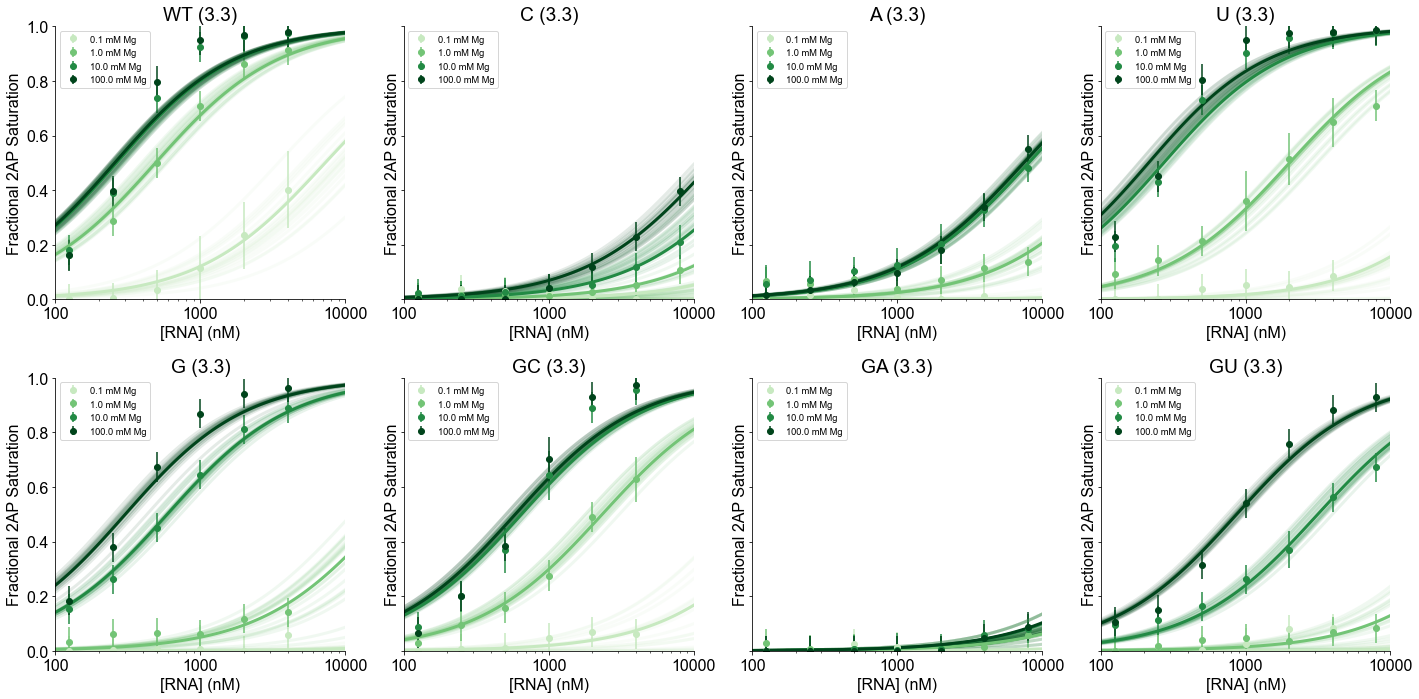

In [10]:
plot_groupedfits(model='3.3',fitter='bayesian',points=True,samples=True,ml_estimates=True,trimmed=True,legend=True)

# Figure S1: Apparent binding model (Kapp) fits for all genotypes

#### Fit standard deviation in shaded regions

Plotting GU: 100%|██████████| 8/8 [00:00<00:00, 25.77it/s]


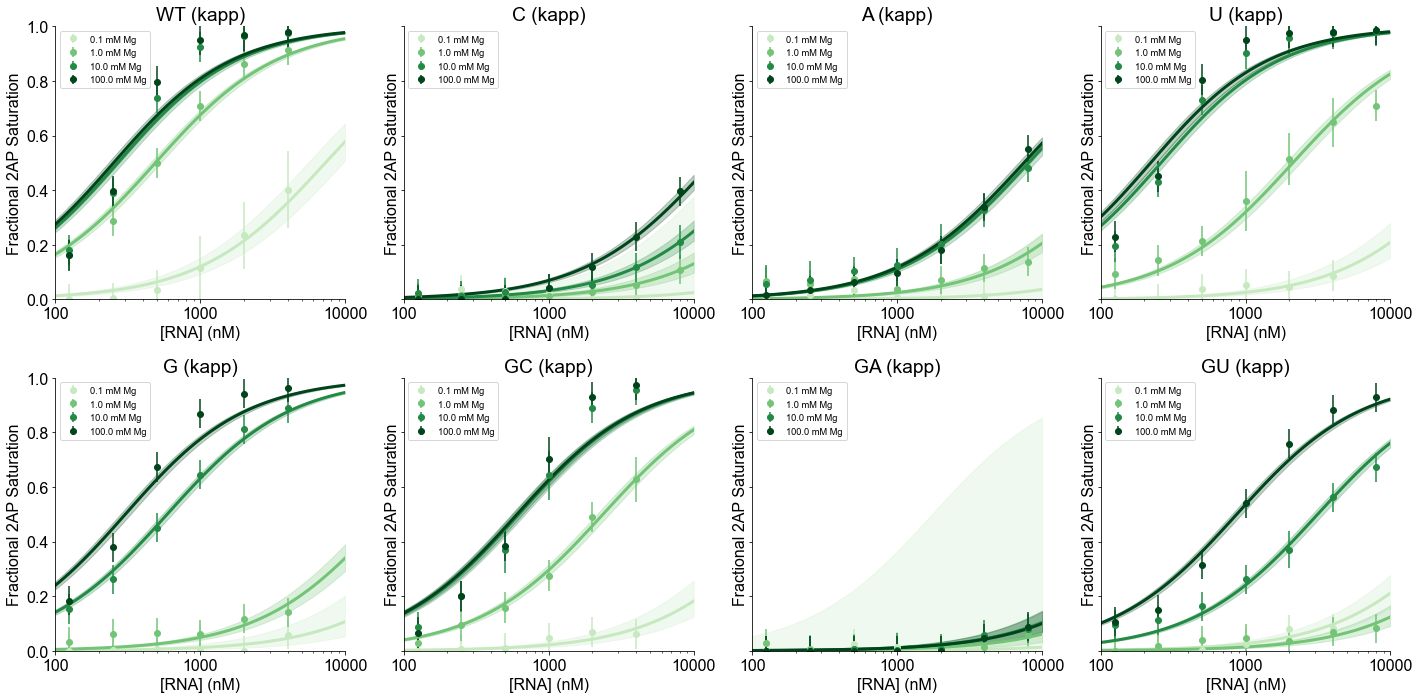

In [11]:
plot_groupedfits(model='kapp',fitter='ml',points=True,estimates=True,legend=True)

## Functions for riboswitch epistasis analysis

### Species populations and energies

In [12]:
def species_frac(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Generate array of RNA fractional populations across Mg concentration range 
    given a model and fit estimates for a genotype (k_estimates).
    
    Calls species_conc from model python script to get concentrations of all
    species (including free 2AP(A) and Mg2+(M) ) but only returns RNA fractional populations. 
    '''
    
    if model.startswith('4'): 
        species = four_state_five_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '3.4':
        species = three_state_four_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '3.3':
        species = three_state_three_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '2.3':
        species = two_state_three_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)

    # Remove free_M and free_A from species list
    rna_species = species[:-2]  
    species_frac = rna_species / np.float64(Rt)
    
    return species_frac

def species_energy(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Generate array of RNA free energies (kcal/mol) with respect to fractional populations
    across Mg concentration range given a model and fit estimates for a genotype (k_estimates).
    
    Calls species_frac to calculate RNA fractional populations.
    '''
    
    rna_fractions = species_frac(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
    species_energy = -R*T*np.log(rna_fractions)
    
    return species_energy

### Equilibrium constant unit conversions

In [13]:
def logk_to_k(model_df,k_nM=False):
    '''Convert logK parameter values in a fit result DataFrame to non-logged nM^-1 or M^-1 units.'''
    
    k_df = model_df.copy(deep=True)
    logk_df = model_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']]
    name_series = model_df.loc[model_df.param != 'n_mg','param']
    
    
    if k_nM:
        logk_to_k = 10**logk_df
        logname_to_kname = name_series.str.replace('logK','(nM^-1)K')
        k_df.loc[model_df.param != 'n_mg','param'] = logname_to_kname
    else:
        logk_to_k = (10**logk_df)*1e9

    k_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] = logk_to_k

    return k_df

def logk_to_k_samples(logk_arr,k_nM=False):
    '''Convert logK parameter values in a fit samples numpy array to non-logged nM^-1 or M^-1 units'''
    
    k_arr = copy.deepcopy(logk_arr)
    if k_nM:
        k_arr[:,:-1] = 10**k_arr[:,:-1] # leave n_mg alone
    else:
        k_arr[:,:-1] = (10**k_arr[:,:-1])*1e9
        
    return k_arr
    
def logk_to_dg(model_df):
    '''Convert logK parameter values in a fit result DataFrame to kcal/mol free energy units'''

    dg_df = model_df.copy(deep=True)
    logk_df = model_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] 
    logk_to_dg = -R*T*np.log((10**logk_df)*1e9)
    dg_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] = logk_to_dg
    
    name_series = model_df.loc[model_df.param != 'n_mg','param']
    logname_to_dgname = name_series.str.replace('logK','dG')
    dg_df.loc[model_df.param != 'n_mg','param'] = logname_to_dgname

    return dg_df

def logk_to_dg_samples(logk_arr):
    '''Convert logK parameter values in a fit samples numpy array to kcal/mol free energy units'''
    
    dg_arr = copy.deepcopy(logk_arr)
    dg_arr[:,:-1] = -R*T*np.log((10**dg_arr[:,:-1])*1e9) # leave n_mg alone
    
    return dg_arr

### Epistasis in fit parameters (equilibrium constants)

In [14]:
def k_epistasis(cycles=CYCLES,model='3.3',fitter='ml',
                dg=False,logK=False,k_nM=False):
    '''
    Generate Dataframe with epistasis within each fit parameter for each mutant cycle given
    a model and fitter.
    
    Epistasis between mutations 1 and 2 with respect to parameter p expressed as the change in p when 
    mutation 1 is introduced into the wildype (0) relative to mutation 2 genetic background.
        epistasis = (p12 - p2) - (p1 - p0)
    
    Epistasis units in kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
    by calling logk_to_dg or logk_to_k unit conversion function.
    '''

    param_ep_list = []
    model_df = get_model_results(model=model,fitter=fitter)
    
    for cycle in cycles:
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        if dg:
            cycle_df = logk_to_dg(cycle_df)

        for param in cycle_df.param.unique():
            p0 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g0)]
            p1 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g1)]
            p2 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g2)]
            p12 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g12)]

            epistasis = (p12.estimate - p2.estimate) - (p1.estimate - p0.estimate)
            ep_low_95 = (p12.low_95 - p2.low_95) - (p1.low_95 - p0.low_95)
            ep_high_95 = (p12.high_95 - p2.high_95) - (p1.high_95 - p0.high_95)
            
            param_ep_df = pd.DataFrame({'cycle':cycle,
                                       'param':param,
                                       'estimate':epistasis,
                                       'low_95':ep_low_95,
                                       'high_95':ep_high_95})
            if (not dg) and (not logK):
                param_ep_df = logk_to_k(param_ep_df,k_nM=k_nM)
                
            param_ep_list.append(param_ep_df)

    k_epistasis_df = pd.concat(param_ep_list)
        
    return k_epistasis_df

def k_epistasis_samples(cycles,model='3.3',fitter='bayesian',
                        dg=False,k_nM=False,logK=False,trimmed=True):
    '''
    Generate dictionary with sample array of epistasis within each fit parameter for each mutant cycle 
    given a model and fitter. Trimmed samples specified with trimmed=True.
    
    Epistasis between mutations 1 and 2 with respect to parameter p expressed as the change in p when 
    mutation 1 is introduced into the wildype (0) relative to mutation 2 genetic background.
        epistasis = (p12 - p2) - (p1 - p0)
    
    Epistasis units in kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
    by calling logk_to_dg_samples or logk_to_k_samples unit conversion function.
    '''
    
    sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
    param_ep_dict = {}
    
    for cycle in cycles:
        cycle_samples = {geno:sample_arr for geno,sample_arr in sample_dict.items() if geno in CYCLE_DICT[cycle]}
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]

        if dg:
            cycle_samples = {geno:logk_to_dg_samples(sample_arr) for geno,sample_arr in cycle_samples.items()}

        param_epistasis = (cycle_samples[g12] - cycle_samples[g2]) - (cycle_samples[g1] - cycle_samples[g0])

        if (not dg) and (not logK):
            param_epistasis = logk_to_k_samples(param_epistasis,k_nM=k_nM)
        
        param_ep_dict[cycle] = param_epistasis
        
    return param_ep_dict

### Experimental observable (g_obs) calculation

In [15]:
def g_obs(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Generate array with the experimental observable (free energy of 2AP-bound relative to 
    2AP-unbound RNA species) across Mg2+ range for a given model and fit estimates for 
    a genotype (k_estimates).
    
    Calls species_energy to get the free energy of each RNA species.
    '''
    
    if model.startswith('4'):
        gE,gD,gEA,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gEA) + np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE) + np.exp(-BETA*gD)
        
    elif model.startswith('3'):
        gE,gD,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE) + np.exp(-BETA*gD)
        
    elif model.startswith('2'):
        gE,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE)
        
    g_obs = -R*T*np.log(bound_part / unbound_part)
    
    return g_obs

def g_obs_ensemble_only(k_est_list,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Generate array with additive experimental observable for double mutant (12) genotype
    (free energy of 2AP-bound relative to 2AP-unbound RNA species) across Mg2+ range 
    by summing together species energies from wildtype (0) and single mutant (1,2) fit estimates.
    
    Calls species_energy to get free energy of each RNA species for the 0,1,2 genotypes
    Additive double mutant energies given by mut1 + mut2 - wt.
    
    If generated by obs_epistasis:
        k_est_list = [df0.estimate,df1.estimate,df2.estimate]
    If generated by obs_epistasis_samples:
        k_est_list = [cycle_samples[g0][pos],cycle_samples[g1][pos],cycle_samples[g2][pos]]
        for each pos in sample array.
    '''
    
    if model.startswith('4'):
        gE0,gD0,gEA0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gD1,gEA1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gD2,gEA2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gEA1+gEA2-gEA0)) + np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) + np.exp(-BETA*(gD1+gD2-gD0))
        
    elif model.startswith('3'):
        gE0,gD0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gD1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gD2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) + np.exp(-BETA*(gD1+gD2-gD0))
        
    elif model.startswith('2'):
        gE0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) 
        
    g_obs_ensemble_only = -R*T*np.log(bound_part / unbound_part)
    
    return g_obs_ensemble_only

### Epistasis in the experimental observable (g_obs)

In [16]:
def obs_epistasis(cycles=CYCLES,model='3.3',fitter='bayesian',
                  Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                  total=False,ensemble_only=False,
                  ep_mg=False,ep_2AP=False):
    '''
    Generate DataFrame with epistasis in the experimental observable (g_obs) for 
    each mutant cycle across the Mg2+ concentration range for a given model and fitter.
    
    Can specify total epistasis (total=True), additive ensemble epistasis (ensemble_only=True).
    
    Also can add contact epistasis in Mg-binding (ep_mg=True) or 2AP-binding (ep_2AP=True) on top of
    additive ensemble epistasis (feature not available in obs_epistasis_samples).
    
    For ensemble_only: calls g_obs_ensemble_only to get observable for double mutant. 
        Otherwise calls g_obs for all genotypes.
        
    Epistasis between mutations 1 and 2 with respect to g_obs expressed as the change in g_obs when 
    mutation 1 is introduced into the wildype (0) relative to mutation 2 genetic background.
        epistasis = (obs12 - obs2) - (obs1 - obs0)
    '''
    
    obs_ep_list = []
    for cycle in cycles:
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        model_df = get_model_results(model=model,fitter=fitter)
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)

        df0 = cycle_df.loc[cycle_df.Geno == g0]
        df1 = cycle_df.loc[cycle_df.Geno == g1]
        df2 = cycle_df.loc[cycle_df.Geno == g2]
        df12 = cycle_df.loc[cycle_df.Geno == g12]


        obs0 = g_obs(df0.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        obs1 = g_obs(df1.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        obs2 = g_obs(df2.estimate,model=model,Rt=Rt,At=At,Mt=Mt)

        if total:
            obs12 = g_obs(df12.estimate,model=model,Rt=Rt,At=At,Mt=Mt)

        elif ensemble_only:
            k_est_list = [df0.estimate,df1.estimate,df2.estimate]
            obs12 = g_obs_ensemble_only(k_est_list,model=model,Rt=Rt,At=At,Mt=Mt)
            
        elif (ep_mg) or (ep_2AP):
            k_ep_df = k_epistasis(cycles=[cycle],model=model,fitter=fitter,logK=True)
            df12_edit = df12.copy(deep=True)
            
            if ep_mg:
                remove_ep_part = k_ep_df.loc[~k_ep_df.param.isin(['logK_mg','n_mg'])]        
            elif ep_2AP:
                remove_ep_part = k_ep_df.loc[~(k_ep_df.param == 'logK_2AP')]
                
            non_ep_df12 = df12_edit.loc[df12_edit.param.isin(remove_ep_part.param)]
            removed_epistasis = non_ep_df12.estimate - remove_ep_part.estimate
            df12_edit.loc[df12_edit.param.isin(remove_ep_part.param),'estimate'] = removed_epistasis
            obs12 = g_obs(df12_edit.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
                

        epistasis = (obs12 - obs2) - (obs1 - obs0)

        obs_ep_list.append(pd.DataFrame({'cycle':cycle,
                                         'total_ep?':total,
                                         'obs_epistasis':epistasis}))

    obs_epistasis_df = pd.concat(obs_ep_list)
        
    return obs_epistasis_df

def obs_epistasis_samples(cycles=CYCLES,model='3.3',fitter='bayesian',
                          sample_frac=0.05,trimmed=True,
                          Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                          total=False,ensemble_only=False):
    '''
    Generate dictionary with epistasis in the experimental observable (g_obs) for 
    each mutant cycle across the Mg2+ concentration range for a given model and fitter.
    
    Can specify total epistasis (total=True or additive ensemble epistasis (ensemble_only=True).
    
    For ensemble_only: calls g_obs_ensemble_only to get observable for double mutant. 
        Otherwise calls g_obs for all genotypes.
    
    Epistasis between mutations 1 and 2 with respect to g_obs expressed as the change in g_obs when 
    mutation 1 is introduced into the wildype (0) relative to mutation 2 genetic background.
        epistasis = (obs12 - obs2) - (obs1 - obs0)
    '''
    
    sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
    obs_ep_dict = {}
    
    for cycle in cycles:
        cycle_samples = {geno:sample_arr for geno,sample_arr in sample_dict.items() if geno in CYCLE_DICT[cycle]}
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        spacing = int(sample_frac*cycle_samples[g0].shape[0])
            
        sample_positions = np.arange(0,cycle_samples[g0].shape[0],spacing)
        obs_ep_arr = np.zeros((sample_positions.shape[0],Mt.shape[0]))
            
        for i,pos in enumerate(sample_positions):
            
            obs0 = g_obs(cycle_samples[g0][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            obs1 = g_obs(cycle_samples[g1][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            obs2 = g_obs(cycle_samples[g2][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            
            if total:
                obs12 = g_obs(cycle_samples[g12][pos],model=model,Rt=Rt,At=At,Mt=Mt)

            elif ensemble_only:
                k_est_list = [cycle_samples[g0][pos],cycle_samples[g1][pos],cycle_samples[g2][pos]]
                obs12 = g_obs_ensemble_only(k_est_list,model=model,Rt=Rt,At=At,Mt=Mt)
        
            epistasis = (obs12 - obs2) - (obs1 - obs0)
            obs_ep_arr[i,:] = epistasis
        
        obs_ep_dict[cycle] = obs_ep_arr
        
    return obs_ep_dict

### Epistasis in apparent 2AP binding (discrete Mg2+ concentrations)

In [17]:
def kapp_epistasis(cycles,model='kapp',fitter='ml'):
    '''
    Generate DataFrame with epistasis specific to the kapp model at 
    four discrete Mg2+ concentrations (0.1,1,10,100 mM) for each mutant cycle.
    
    Epistasis between mutations 1 and 2 with respect to the apparent free energy of 2AP binding (dG_app) 
    expressed as the change in dG_app when mutation 1 is introduced into the wildype (0) 
    relative to mutation 2 genetic background.
        epistasis = (dG_app12 - dG_app2) - (dG_app1 - dG_app0)
        
    Epistasis calculations also performed for 95% confidence interval.
    '''
    
    kapp_ep_list = []
    for cycle in cycles:
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
    
        model_df = get_model_results(model=model,fitter=fitter)
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)
        cycle_df = logk_to_dg(cycle_df)

        df0 = cycle_df.loc[cycle_df.Geno == g0]
        df1 = cycle_df.loc[cycle_df.Geno == g1]
        df2 = cycle_df.loc[cycle_df.Geno == g2]
        df12 = cycle_df.loc[cycle_df.Geno == g12]
        
        apparent_ep = (df12.estimate - df2.estimate) - (df1.estimate - df0.estimate)
        ep_low_95 = (df12.low_95 - df2.low_95) - (df1.low_95 - df0.low_95)
        ep_high_95 = (df12.high_95 - df2.high_95) - (df1.high_95 - df0.high_95)
        
        kapp_ep_list.append(pd.DataFrame({'cycle':cycle,
                                         'Mg':df0.Mg,
                                         'apparent_ep':apparent_ep,
                                         'ep_low_95':ep_low_95,
                                         'ep_high_95':ep_high_95}))
        
    kapp_epistasis_df = pd.concat(kapp_ep_list)
    
    return kapp_epistasis_df

## Plotting functions

### Single plot generation functions

In [18]:
def plot_pops(geno='xxxxx',model='3.3',fitter='ml',ml_estimates=False,
              samples=False,sample_frac=0.05,trimmed=True,
              Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
              alpha=1,ax=None,title=None,legend=True):
    '''
    Plot fractional RNA species populations as a function of the Mg2+ concentration 
    for a genotype given a model and fitter. Returns None.
    
    Calls species_frac to get populations.
    
    If plotting multiple samples (samples=True), can overlay the ML result (ml_estimates=True).
    
    Plot coloration matches the color scheme in the manuscript:
        E - orange, D - blue, EA - gray, DA - purple
    '''
    
    pos_dict = {0:'E',1:'D',2:'EA',-1:'DA'}
    
    if ml_estimates:
        model_df = get_model_results(model=model,fitter='ml')
        model_geno_df = model_df.loc[model_df.Geno == geno]
    
        rna_fractions = species_frac(model_geno_df.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        ax.plot(Mt*1e-6,rna_fractions[0],lw=3,alpha=alpha,color='orange',label='E')
        if len(rna_fractions) >= 4:
            ax.plot(Mt*1e-6,rna_fractions[2],lw=3,alpha=alpha,color='gray',label='EA')
        if len(rna_fractions) >= 3: 
            ax.plot(Mt*1e-6,rna_fractions[1],lw=3,alpha=alpha,color='cornflowerblue',label='D')
        ax.plot(Mt*1e-6,rna_fractions[-1],lw=3,alpha=alpha,color='purple',label='DA')
        
    if samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        geno_arr = sample_dict[geno]
        
        spacing = int(sample_frac*geno_arr.shape[0])
        alpha=0.1

        sample_positions = np.arange(0,geno_arr.shape[0],spacing)
        for pos in sample_positions:
            rna_fractions = species_frac(geno_arr[pos],model=model,Rt=Rt,At=At,Mt=Mt)
            ax.plot(Mt*1e-6,rna_fractions[0],lw=3,alpha=alpha,color='orange',label='_nolegend_')
            if len(rna_fractions) >= 4:
                ax.plot(Mt*1e-6,rna_fractions[2],lw=3,alpha=alpha,color='gray',label='_nolegend_')
            if len(rna_fractions) >= 3: 
                ax.plot(Mt*1e-6,rna_fractions[1],lw=3,alpha=alpha,color='cornflowerblue',label='_nolegend_')
            ax.plot(Mt*1e-6,rna_fractions[-1],lw=3,alpha=alpha,color='purple',label='_nolegend_')
    
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.set_ylabel('Fractional Population')
    ax.set_ylim(0,1)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    if legend:
        ax.legend(loc='center left',fontsize='x-small')

    return None

            
def plot_energies(geno='xxxxx',model='3.3',fitter='bayesian',ml_estimates=False,
                  samples=False,sample_frac=0.05,trimmed=True,
                  Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                  alpha=1,ax=None,ylim=None,title=None,legend=True):
    '''
    Plot relative free energy of each RNA species in kcal/mol as a function of the 
    Mg2+ concentration for a genotype given a model and fitter. Returns None.
     
    Calls species_energy to get RNA free energies.
    
    If plotting multiple samples (samples=True), can overlay the ML result (ml_estimates=True).
    
    Providing a ylim tuple (eg ylim=(0,10)) sets bounds on the y-axis.
    
    Plot coloration matches the color scheme in the manuscript:
        E - orange, D - blue, EA - gray, DA - purple
    '''
    
    pos_dict = {0:'E',1:'D',2:'EA',-1:'DA'}
    
    if ml_estimates:
        model_df = get_model_results(model=model,fitter='ml')
        model_geno_df = model_df.loc[model_df.Geno == geno]
    
        rna_energies = species_energy(model_geno_df.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        ax.plot(Mt*1e-6,rna_energies[0],lw=3,alpha=alpha,color='orange',label='E')
        if len(rna_energies) >= 4:
            ax.plot(Mt*1e-6,rna_energies[2],lw=3,alpha=alpha,color='gray',label='EA')
        if len(rna_energies) >= 3: 
            ax.plot(Mt*1e-6,rna_energies[1],lw=3,alpha=alpha,color='cornflowerblue',label='D')
        ax.plot(Mt*1e-6,rna_energies[-1],lw=3,alpha=alpha,color='purple',label='DA')
        
    elif samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        geno_arr = sample_dict[geno]
        
        spacing = int(sample_frac*geno_arr.shape[0])
        alpha=0.1
            
        sample_positions = np.arange(0,geno_arr.shape[0],spacing)
        for pos in sample_positions:
            rna_energies = species_energy(geno_arr[pos],model=model,Rt=Rt,At=At,Mt=Mt)
            ax.plot(Mt*1e-6,rna_energies[0],lw=3,alpha=alpha,color='orange',label='_nolegend_')
            if len(rna_energies) >= 4:
                ax.plot(Mt*1e-6,rna_energies[2],lw=3,alpha=alpha,color='gray',label='_nolegend_')
            if len(rna_energies) >= 3: 
                ax.plot(Mt*1e-6,rna_energies[1],lw=3,alpha=alpha,color='cornflowerblue',label='_nolegend_')
            ax.plot(Mt*1e-6,rna_energies[-1],lw=3,alpha=alpha,color='purple',label='_nolegend_')

    ax.set_title(title)
    ax.axhline(color='black',lw=1)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.set_ylabel('dG')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    if ylim is not None:
        ax.set_ylim(ylim)
    if legend:
        ax.legend(loc='upper right',fontsize='x-small')

    return None

def plot_k(geno='xxxxx',model='3.3',fitter='ml',dg=False,k_nM=False,logK=False,
           samples=False,trimmed=True,ninetyfive=False,ylim=None,
           ax=None,title=None,legend=True):
    '''
    Plot a bar chart with value of each fit parameter (equilibrium constant)
    for a genotype given a model and fitter. Returns None.
    
    Specify fit parameter units:
        kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
    Calls logk_to_dg or logk_to_k for unit conversions.
    
    Providing a ylim tuple (eg ylim=(0,10)) sets bounds on the y-axis.
    
    Error bars with 95 percent confidence interval generated with ninetyfive=True.
    Orange dots for each bayesian sample added if samples=True.
        Note: Bayesian samples plotted even if fitter='ml' for the bar chart.
    '''
    
    model_df = get_model_results(model=model,fitter=fitter)
    model_geno_df = model_df.loc[model_df.Geno == geno]
    x_spacing = np.arange(len(model_geno_df.param.unique()))
    
    if dg:
        conv_df = logk_to_dg(model_geno_df)
    elif logK:
        conv_df = model_geno_df.copy(deep=True)
    elif (not dg) and (not logK):
        conv_df = logk_to_k(model_geno_df,k_nM=k_nM)
                          
    conv_df.plot.bar(x='param',y='estimate',ax=ax,alpha=0.5,legend=False)
    
    if ninetyfive:
        ax.vlines(x_spacing,conv_df.low_95,conv_df.high_95,color='black')
           
    if samples:
        sample_dict = get_model_samples(model=model,fitter='bayesian',trimmed=trimmed)
        geno_arr = sample_dict[geno]
        if dg:
            geno_arr = logk_to_dg_samples(geno_arr)
        if (not dg) and (not logK):
            geno_arr = logk_to_k_samples(geno_arr,k_nM=k_nM)
            
        for i,pos in enumerate(x_spacing):
            x = [pos]*geno_arr.shape[0]
            ax.scatter(x,geno_arr[:,i],color='orange',alpha=0.5,linewidth=0.5,s=1)
        
    ax.set_title(title)
    if dg:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('dG (kcal/mol)')
    elif logK:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('logK (nM^-1)')
    else:
        ax.axhline(1,color='black',lw=1)
        ax.set_yscale('log')
        if k_nM:
            ax.set_ylabel('K (nM^-1)')
        else:
            ax.set_ylabel('K (M^-1)')
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return None

def plot_k_epistasis(cycle='GC',model='3.3',fitter='ml',
                     dg=False,k_nM=False,logK=False,
                     samples=False,trimmed=True,ninetyfive=False,
                     ylim=None,ax=None,title=None,legend=True):
    '''
    Plot a bar chart with epistasis in each fit parameter (equilibrium constant)
    for a mutant cycle given a model and fitter. Returns None.
    
    Calls k_epistasis (samples=False) or k_epistasis samples (sample=True) for epistasis.
    
    Specify fit parameter epistasis units:
        kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
    Calls logk_to_dg or logk_to_k for unit conversions.
    
    Providing a ylim tuple (eg ylim=(0,10)) sets bounds on the y-axis.
    
    Error bars with 95 percent confidence interval generated with ninetyfive=True.
    Orange dots for each bayesian sample added if samples=True.
        Note: Bayesian samples plotted even if fitter='ml' for the bar chart
    '''
    
    k_epistasis_df = k_epistasis(cycles=[cycle],model=model,fitter=fitter,dg=dg,k_nM=k_nM,logK=logK)
    x_spacing = np.arange(len(k_epistasis_df.param.unique()))
    k_epistasis_df.plot.bar(x='param',y='estimate',ax=ax,alpha=0.5,legend=False)
    
    if ninetyfive:
        ax.vlines(x_spacing,k_epistasis_df.low_95,k_epistasis_df.high_95,color='black')
        
    if samples:
        cycle_ep_dict = k_epistasis_samples(cycles=[cycle],model=model,fitter='bayesian',dg=dg,k_nM=k_nM,logK=logK,trimmed=trimmed)
        ep_arr = cycle_ep_dict[cycle]
        for i,pos in enumerate(x_spacing):
            x = [pos]*ep_arr.shape[0]
            ax.scatter(x,ep_arr[:,i],color='orange',alpha=0.5,linewidth=0.5,s=1)
        
    ax.set_title(title)
    
    if dg:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('Epistasis (kcal/mol)')
    elif logK:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('Epistasis (log(nM-1))')
    else:
        ax.axhline(1,color='black',lw=1)
        ax.set_yscale('log')
        if k_nM:
            ax.set_ylabel('Epistasis (nM^-1)')
        else:
            ax.set_ylabel('Epistasis (M^-1)')
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return None

def plot_obs_epistasis(cycle='GC',model='3.3',fitter='bayesian',
                       ml_estimates=False,ninetyfive=False,kapp=False,
                       samples=False,sample_frac=0.05,trimmed=True,
                       total=False,ensemble_only=False,ep_mg=False,ep_2AP=False,
                       alpha=1,ylim=None,ax=None,title=None,legend=True):
    '''
    Plot epistasis in the experimental observable (g_obs) for each mutant cycle across 
    the Mg2+ concentration range for a given model and fitter. Returns None.
    
    Calls obs_epistasis to calculate epistasis in the observable.
    If samples=True, calls obs_epistasis_samples instead.
    
    If plotting multiple samples (samples=True), can overlay the ML result (ml_estimates=True).
    
    Can specify total epistasis in blue (total=True), additive ensemble epistasis in red (ensemble_only=True),
    and apparent binding epistasis as discrete cyan dots (kapp=True).
    
    When ml_estimates=True, can add contact epistasis in Mg-binding in orange (ep_mg=True) or 
    2AP-binding in pink (ep_2AP=True) on top of additive ensemble epistasis. Also can plot 
    95 percent confidence interval with ninetyfive=True for total or ensemble_only epistasis (risk of instability).
 
    Multiple types of epistasis can be plotted simultaneously.
    '''
    
    if ml_estimates:
        if total:
            total_ep_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',total=True)
            ax.plot(MG_RANGE_mM,total_ep_df.obs_epistasis,lw=3,alpha=alpha,color='blue',label='total')
            if ninetyfive:
                ax.fill_between(MG_RANGE_mM,total_ep_df.ep_low_95,total_ep_df.ep_high_95,alpha=0.1,color='blue') 
        if ensemble_only:
            ensemble_only_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ensemble_only=True)
            ax.plot(MG_RANGE_mM,ensemble_only_df.obs_epistasis,lw=3,alpha=alpha,color='red',label='ensemble only')
            if ninetyfive:
                ax.fill_between(MG_RANGE_mM,ensemble_only_df.ep_low_95,ensemble_only_df.ep_high_95,alpha=0.1,color='red')
        if ep_mg:
            ep_mg_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ep_mg=True)
            ax.plot(MG_RANGE_mM,ep_mg_df.obs_epistasis,lw=3,alpha=alpha,color='orange',label='ep_mg')
        if ep_2AP:
            ep_2AP_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ep_2AP=True)
            ax.plot(MG_RANGE_mM,ep_2AP_df.obs_epistasis,lw=3,alpha=alpha,color='pink',label='ep_2AP')
    
    else:
        if total:
            total_ep_df = obs_epistasis(cycles=[cycle],model=model,fitter=fitter,total=True)
            ax.plot(MG_RANGE_mM,total_ep_df.obs_epistasis,lw=3,alpha=alpha,color='blue',label='total')
        if ensemble_only:
            ensemble_only_df = obs_epistasis(cycles=[cycle],model=model,fitter=fitter,ensemble_only=True)
            ax.plot(MG_RANGE_mM,ensemble_only_df.obs_epistasis,lw=3,alpha=alpha,color='red',label='ensemble only')
            

    if samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        if total:
            total_ep_dict = obs_epistasis_samples(cycles=[cycle],model=model,fitter=fitter,sample_frac=sample_frac,total=True)
            for i in range(total_ep_dict[cycle].shape[0]):
                ax.plot(MG_RANGE_mM,total_ep_dict[cycle][i],lw=3,alpha=0.1,color='blue',label='_nolegend_')
        if ensemble_only:
            ensemble_only_dict = obs_epistasis_samples(cycles=[cycle],model=model,fitter=fitter,sample_frac=sample_frac,ensemble_only=True)
            for i in range(total_ep_dict[cycle].shape[0]):
                ax.plot(MG_RANGE_mM,ensemble_only_dict[cycle][i],lw=3,alpha=0.1,color='red',label='_nolegend_')
        
    if kapp:
        kapp_ep_df = kapp_epistasis(cycles=[cycle])
        ax.scatter(kapp_ep_df.Mg,kapp_ep_df.apparent_ep,s=30,color='cyan',label='apparent')
        ax.vlines(kapp_ep_df.Mg,kapp_ep_df.ep_low_95,kapp_ep_df.ep_high_95,color='cyan')
            
    ax.set_title(title)
    ax.axhline(color='black',lw=1)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylabel('Epistasis (kcal/mol)')
    if ylim is not None:
        ax.set_ylim(ylim)
    #else:
    #    ax.set_ylim(-5,5)
    ax.set_box_aspect(1)
    if legend:
        ax.legend(loc='lower right',fontsize='x-small') 
        
    return None

        

### Grouped plot generation functions

In [19]:
def plot_geno_group(genos=GENOS,model='3.3',fitter='ml',
                    samples=False,trimmed=True,ml_estimates=False,ninetyfive=False,
                    pops=False,energies=False,k_estimates=False,
                    dg=False,k_nM=False,logK=False,ylim=False,
                    sample_frac=0.05,alpha=1,legend=True,savefig=False,file=None):
    '''
    Organizing scheme for plots involving all 8 genotypes (4 per row) for a given model and fitter.
    Returns None.
    
    Options: 
    + plot RNA species populations by calling plot_pops (pops=True)
    
    + plot RNA species energies by calling plot_energies (energies=True)
    
    + generate parameter estimate bar charts with plot_k (k_estimates=True)
        Specify fit parameter units for plot_k (usually dg=True):
            kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
        Error bars with 95 percent confidence interval generated with ninetyfive=True.
        Orange dots for each bayesian sample added if samples=True.
            Note: Bayesian samples plotted even if fitter='ml' for the bar chart
        Providing a ylim tuple (eg ylim=(0,10)) sets bounds on the y-axis.
    
    If plotting multiple samples (samples=True), can overlay the ML result (ml_estimates=True).
    '''

    fig, axes = plt.subplots(ncols=4,nrows=2,sharey=True,squeeze=False,figsize=(20,10)) 
    
    pbar = tqdm(range(8))
    for i in pbar:
        geno = genos[i]
        pbar.set_description("Plotting %s" % GENO_DICT[geno])
        
        #organize subplot layout 
        j = 0
        k = i
        if i >= 4:
            j = 1
            k = i-4
            
        if pops:
            plot_pops(geno=geno,model=model,fitter=fitter,samples=samples,
                      sample_frac=sample_frac,ml_estimates=ml_estimates,
                      trimmed=trimmed,alpha=alpha,ax=axes[j,k],
                      legend=legend,title=f'{GENO_DICT[geno]} ({model})')
        if energies:
            plot_energies(geno=geno,model=model,fitter=fitter,samples=samples,
                          sample_frac=sample_frac,ml_estimates=ml_estimates,
                          trimmed=trimmed,alpha=alpha,ax=axes[j,k],
                          legend=legend,title=f'{GENO_DICT[geno]} ({model})')         
        if k_estimates:
            plot_k(geno=geno,model=model,fitter=fitter,samples=samples,ninetyfive=ninetyfive,
                   trimmed=trimmed,dg=dg,k_nM=k_nM,logK=logK,ylim=ylim,
                   ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})') 
        
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None


def plot_epistasis_cycles(cycles=CYCLES,model='3.3',fitter='ml',
                          samples=False,ml_estimates=False,sample_frac=0.05,trimmed=True,
                          k_epistasis=False,dg=False,k_nM=False,logK=False,ylim=None,ninetyfive=False,
                          obs_epistasis=False,total=False,ensemble_only=False,ep_mg=False,ep_2AP=False,kapp=True,
                          alpha=1,legend=True,savefig=False,file=None):
    '''
    Organizing scheme for epistasis plots for all three mutant cycles (single row). Returns None.
    
    Options: 
    + plot bar charts with epistasis in fit parameters (k_epistasis=True) by calling plot_k_epistasis
        Specify fit parameter units for plot_k_epistasis (usually dg=True):
            kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False)
        Error bars with 95 percent confidence interval generated with ninetyfive=True.
        Orange dots for each bayesian sample added if samples=True.
            Note: Bayesian samples plotted even if fitter='ml' for the bar chart
        Providing a ylim tuple (eg ylim=(0,10)) sets bounds on the y-axis.
    
    + plot mg-dependent epistasis curves in the experimental observable (obs_epistasis=True) by calling plot_obs_epistasis
        Multiple types of epistasis can be plotted simultaneously (usually total=True, ensemble_only=True, kapp=True).
            Total epistasis in blue (total=True),
            Additive ensemble epistasis in red (ensemble_only=True),
            Apparent binding epistasis as discrete cyan dots (kapp=True).
    
        When ml_estimates=True, can add contact epistasis in Mg-binding in orange (ep_mg=True) or 
        2AP-binding in pink (ep_2AP=True) on top of additive ensemble epistasis. 
        Also can plot 95 percent confidence interval with ninetyfive=True for total or 
        ensemble_only epistasis (risk of instability).

        If plotting multiple samples (samples=True), can overlay the ML result (ml_estimates=True).
    '''
    
    fig, axes = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=True,
                             squeeze=False,figsize=(15,5))
    
    pbar = tqdm(cycles)
    for i,cycle in enumerate(pbar):
        pbar.set_description("processing %s" % cycles[i])
        
        if k_epistasis:
            plot_k_epistasis(cycle=cycle,model=model,fitter=fitter,dg=dg,k_nM=k_nM,logK=logK,
                             samples=samples,trimmed=trimmed,ninetyfive=ninetyfive,
                             ylim=ylim,ax=axes[0,i],title=cycle)
        
        if obs_epistasis:
            plot_obs_epistasis(cycle=cycle,model=model,fitter=fitter,samples=samples,trimmed=trimmed,
                               sample_frac=sample_frac,ml_estimates=ml_estimates,ninetyfive=ninetyfive,
                               kapp=kapp,total=total,ensemble_only=ensemble_only,ep_mg=ep_mg,ep_2AP=ep_2AP,
                               ax=axes[0,i],legend=legend,title=cycle)
            
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None


# Figure 2B: Mg-dependent RNA fractional populations for all genotypes fit to 3.3 ensemble model

#### Bayesian samples with ML fit overlay

Plotting GU: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


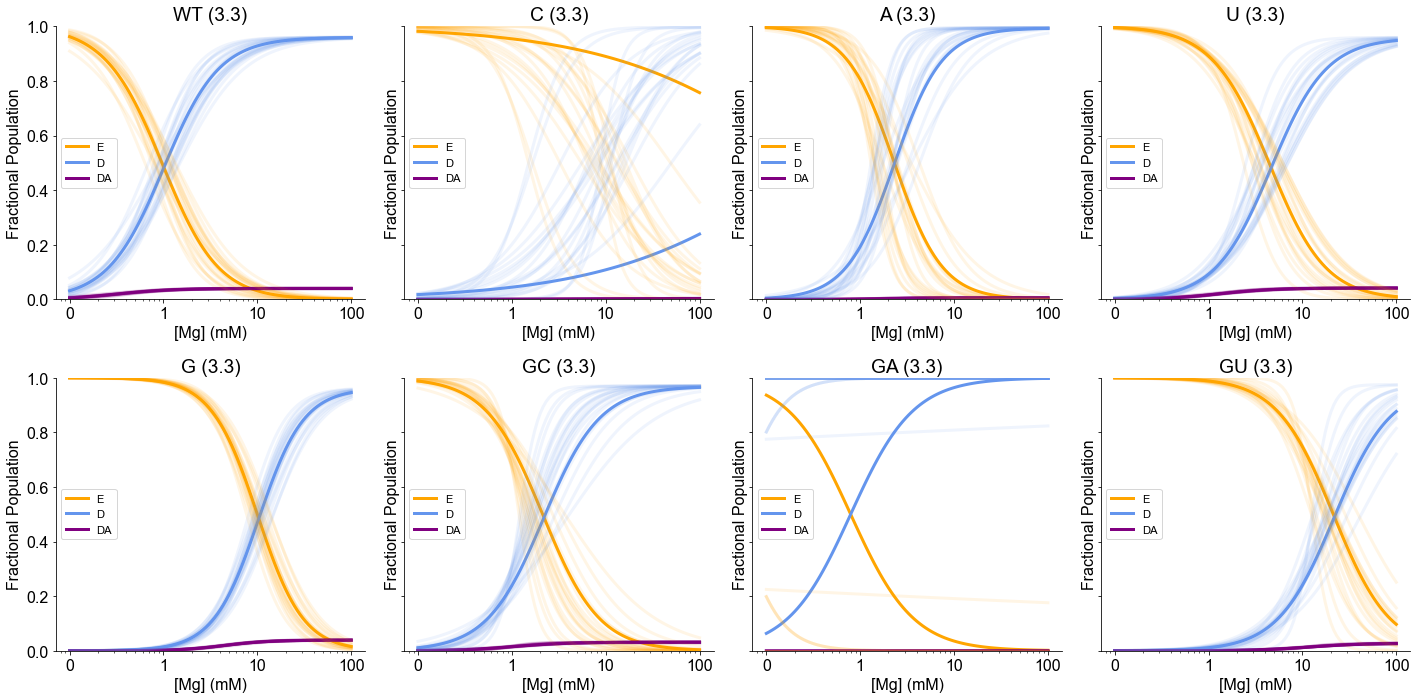

In [20]:
plot_geno_group(genos=GENOS,model='3.3',fitter='bayesian',samples=True,ml_estimates=True,pops=True)

# Figure 4: Fit parameters for each genotype from 3.3 model in free energy units

#### ML estimates as bars, Bayesian samples as orange dots

Plotting GU: 100%|██████████| 8/8 [00:00<00:00, 15.86it/s]


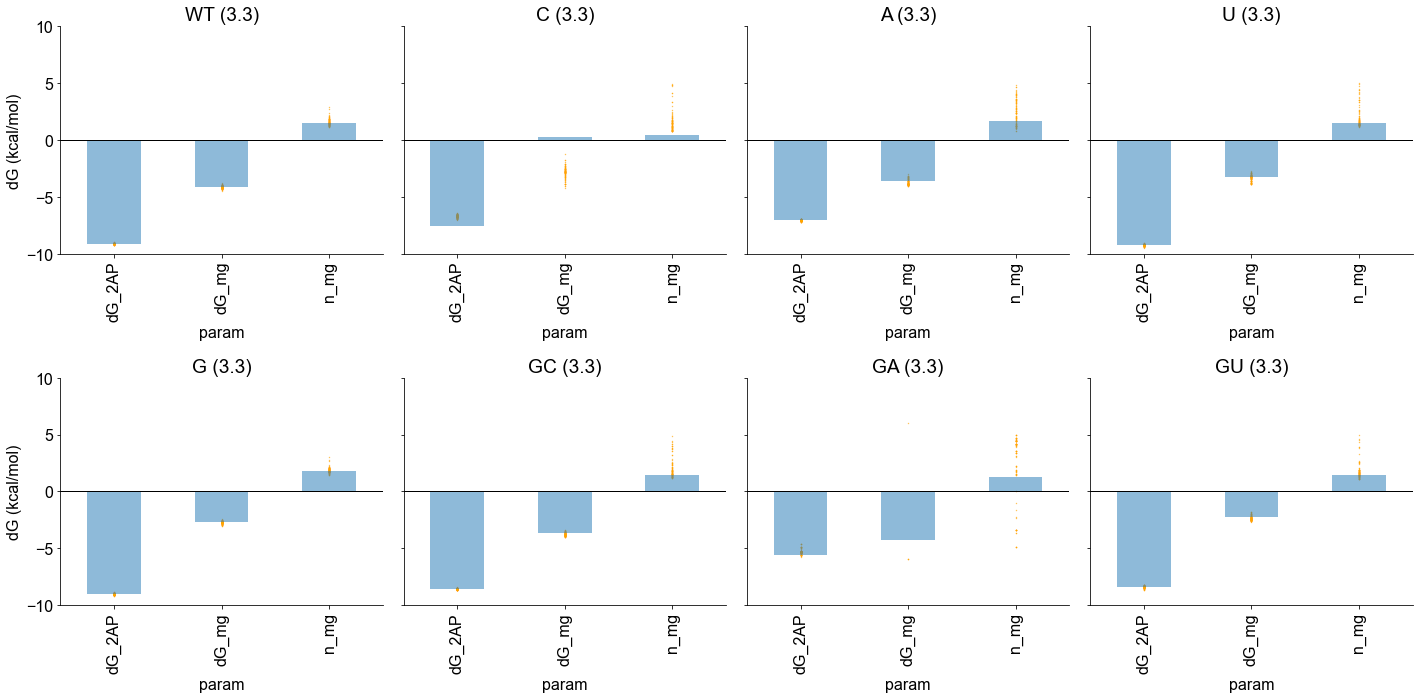

In [21]:
plot_geno_group(genos=GENOS,model='3.3',fitter='ml',samples=True,ninetyfive=False,k_estimates=True,dg=True,ylim=(-10,10))

# Figure 6A: Epistasis in fit parameters from 3.3 model for GC, GA, GU mutant cycles

#### ML estimates as bars, Bayesian samples as orange dots

processing GU: 100%|██████████| 3/3 [00:00<00:00, 19.06it/s]


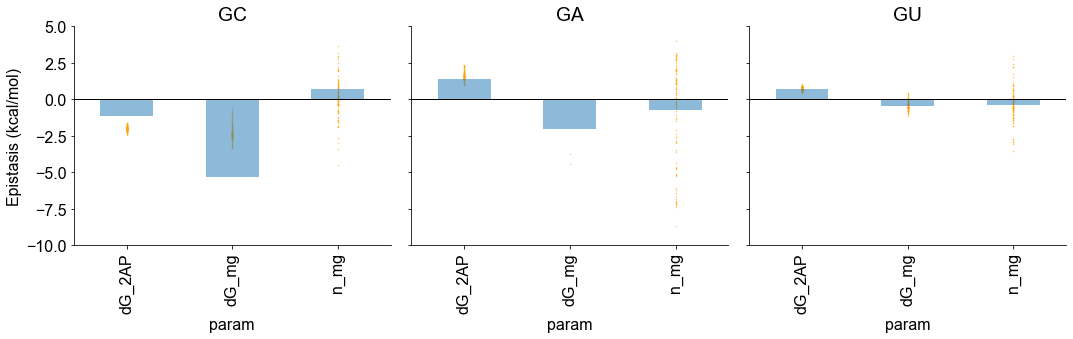

In [22]:
plot_epistasis_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=True,dg=True,
                      k_epistasis=True,ninetyfive=False,ylim=(-10,5))

# Figure 6B: Mg-dependent epistasis in 3.3 model experimental observable for GC, GA, GU mutant cycles

#### Bayesian samples with ML fit overlay

processing GU: 100%|██████████| 3/3 [01:07<00:00, 22.41s/it]


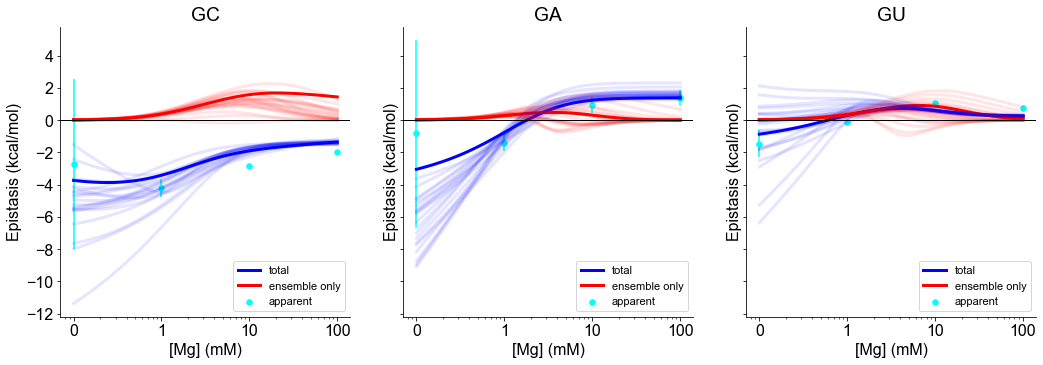

In [23]:
plot_epistasis_cycles(cycles=CYCLES,model='3.3',fitter='bayesian',samples=True,ml_estimates=True,
                      obs_epistasis=True,total=True,ensemble_only=True,kapp=True)

# Figure S2: Contact epistasis in Mg-binding and 2AP-binding for 3.3 model experimental observable

#### All ML fit estimates

processing GU: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


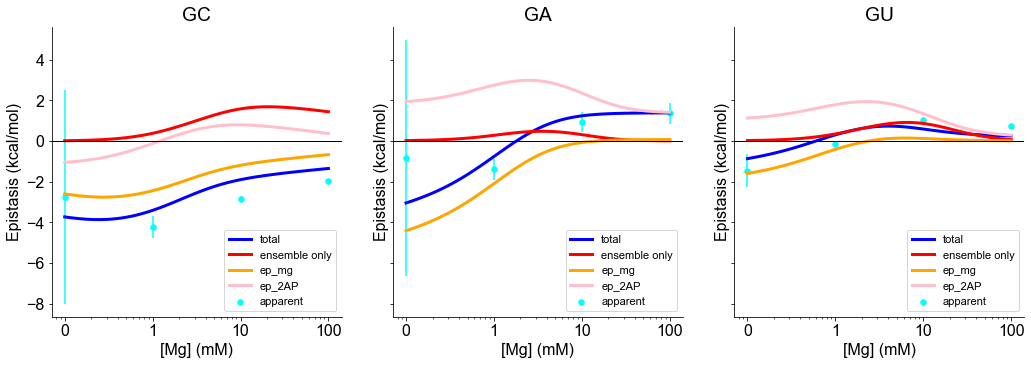

In [24]:
plot_epistasis_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=False,ml_estimates=True,
                      obs_epistasis=True,total=True,ensemble_only=True,ep_mg=True,ep_2AP=True,kapp=True)